In [4]:
import os
import psycopg2
import networkx as nx
from dotenv import load_dotenv
load_dotenv()

def create_postgres_conn(db_alias):
    '''
    Create connection to postgres database
    '''
    host = os.environ.get(f'{db_alias}_POSTGRES_HOSTNAME')
    database = os.environ.get(f'{db_alias}_POSTGRES_DB')
    user = os.environ.get(f'{db_alias}_POSTGRES_USERNAME')
    password = os.environ.get(f'{db_alias}_POSTGRES_PASSWORD')

    # Establish the connection
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    return conn

In [21]:
def get_dependent_tbls(tbl_name):
    conn = create_postgres_conn('V4_STAGING')
    cursor = conn.cursor()
    query = f"""
        SELECT DISTINCT conrelid::regclass AS dependent_table
        FROM pg_constraint
        WHERE confrelid = '{tbl_name}'::regclass;
    """

    cursor.execute(query)
    relationships = cursor.fetchall()

    # Close the cursor and the database connection
    cursor.close()
    conn.close()
    return relationships


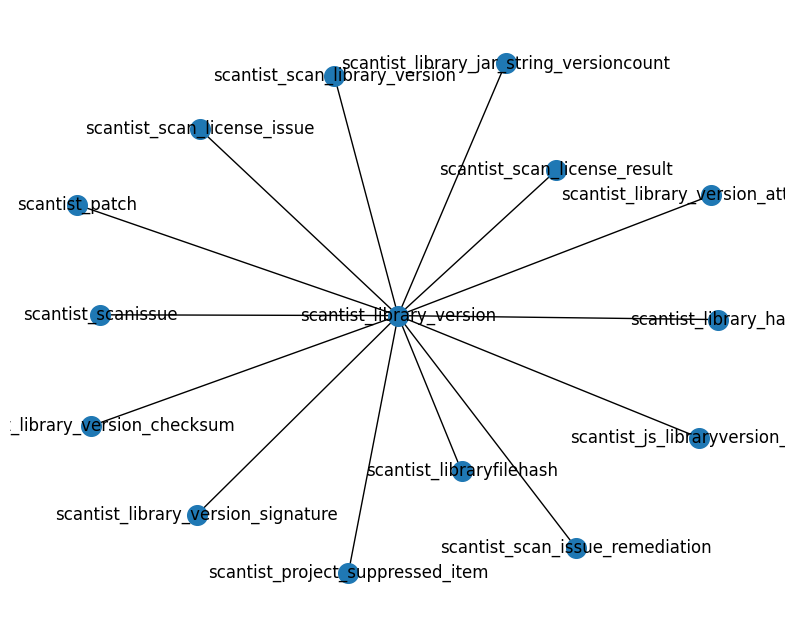

In [39]:
G = nx.Graph()
tbl_name='scantist_library_version'
for relationship in get_dependent_tbls(tbl_name):
    dependent_table = relationship[0]
    constraint_name = ''
    G.add_edge(tbl_name, dependent_table, constraint_name=constraint_name)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G)  # Layout algorithm, you can choose other layouts as well

edge_labels = nx.get_edge_attributes(G, 'constraint_name')
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')
plt.show()



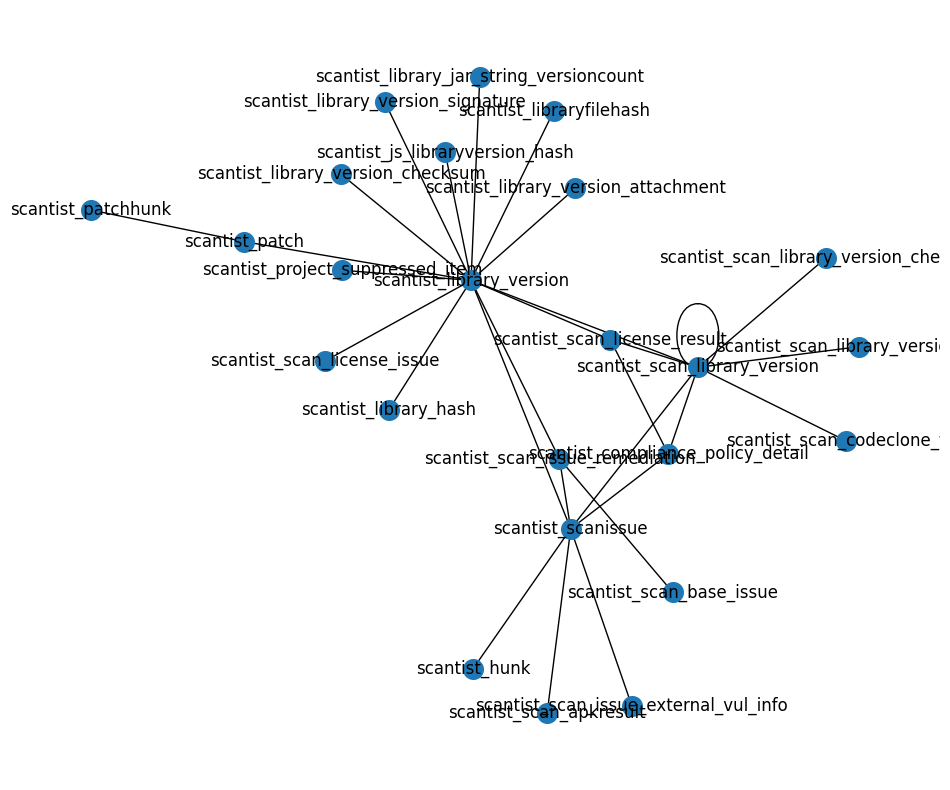

In [40]:
# Add an edge between the existing node and the new node
for dep in get_dependent_tbls(tbl_name):
    relations = get_dependent_tbls(dep[0])
    for relation in relations:
        G.add_edge(dep[0], relation[0], constraint_name='')

plt.figure(figsize=(12, 10)) 
# Visualize the updated graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'constraint_name')
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis('off')

plt.show()